<a href="https://colab.research.google.com/github/CepbluKot/ecology_ml/blob/main/ecology_ml_w_data_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1140]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('data.csv')
df=df.drop(['X','Y','ObjectID','code', 'area', 'ID', 'texture', 'parentrock', 'relief', 'soil_name', 'Al ммоль-экв/100г'], axis=1)
df.head(5)

,pHH20,pHKCl,Гумус %,P мг/кг,K мг/кг,Mn мг/кг,Co мг/кг,Cu мг/кг,Zn мг/кг,Mo мг/кг,B мг/кг,Ca ммоль-экв/100г,Mg ммоль-экв/100г,N_NH4 мг/кг,N_NO3 мг/кг,Z,NDVI
0,5.8,5.0,6.5,81.1,178.3,24.1,0.04,0.06,0.21,0.0,2.2,13.7,2.7,8.9,40.8,1.706668,0.727741
1,5.9,5.1,6.2,262.9,328.8,29.0,0.04,0.07,0.18,0.0,2.6,14.3,2.6,12.1,43.4,1.811376,0.658671
2,5.7,4.9,7.4,202.3,255.5,27.9,0.04,0.10,0.25,0.0,2.1,12.5,2.5,9.0,24.3,1.891337,0.768856
3,5.9,5.0,7.2,66.7,136.8,15.1,0.03,0.10,0.37,0.0,2.3,14.4,2.7,9.1,21.8,1.919135,0.722283
4,5.7,5.0,6.7,68.0,210.7,22.9,0.04,0.06,0.22,0.0,2.0,12.5,2.3,8.2,24.1,1.609458,0.700665


<AxesSubplot: >

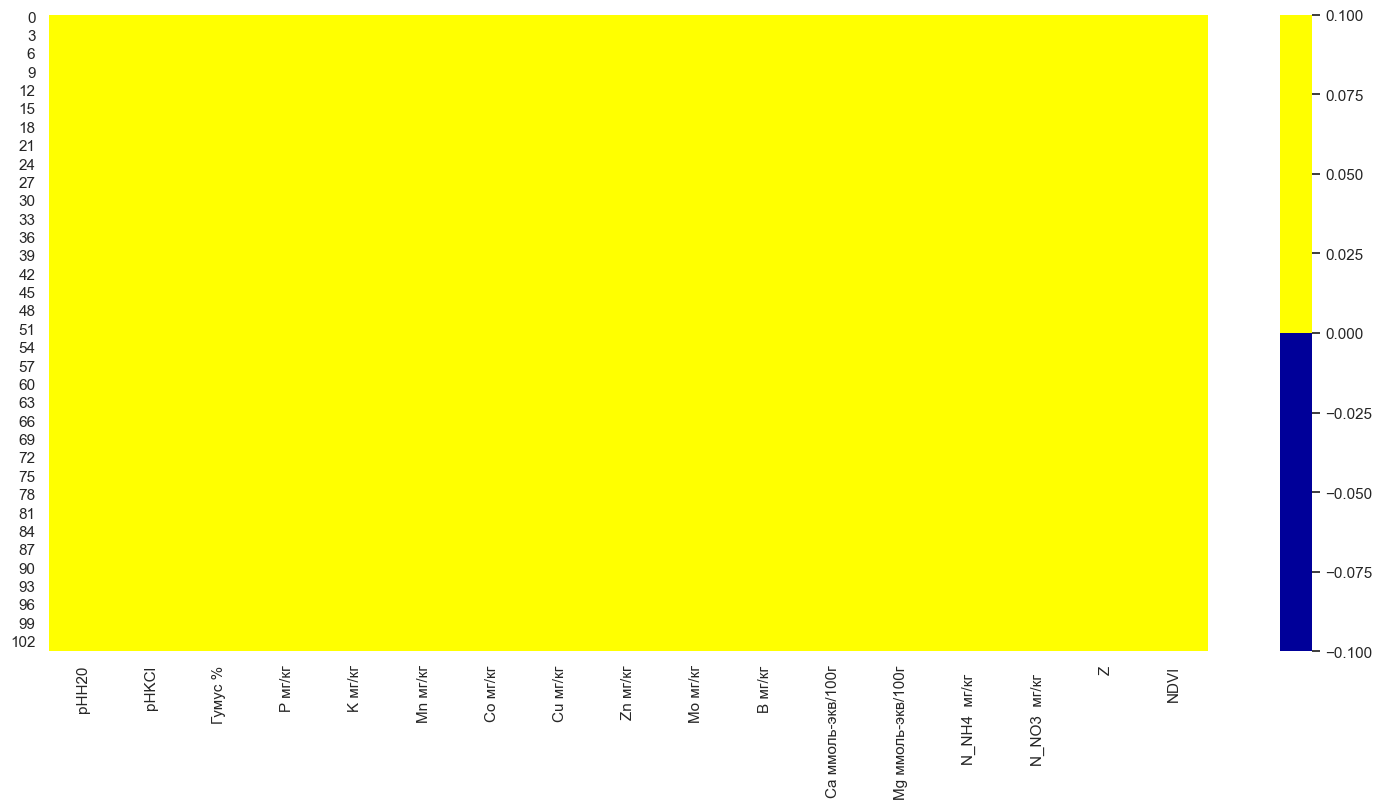

In [1141]:
colours = ['#000099', '#ffff00'] 
sns.heatmap(df.isnull(), cmap=sns.color_palette(colours))

In [1142]:
df = df.drop_duplicates()


print(df.shape)
print(df_dedupped.shape)

(104, 17)
(104, 17)


In [1143]:
X=df.drop('NDVI',axis=1)
y=df['NDVI']

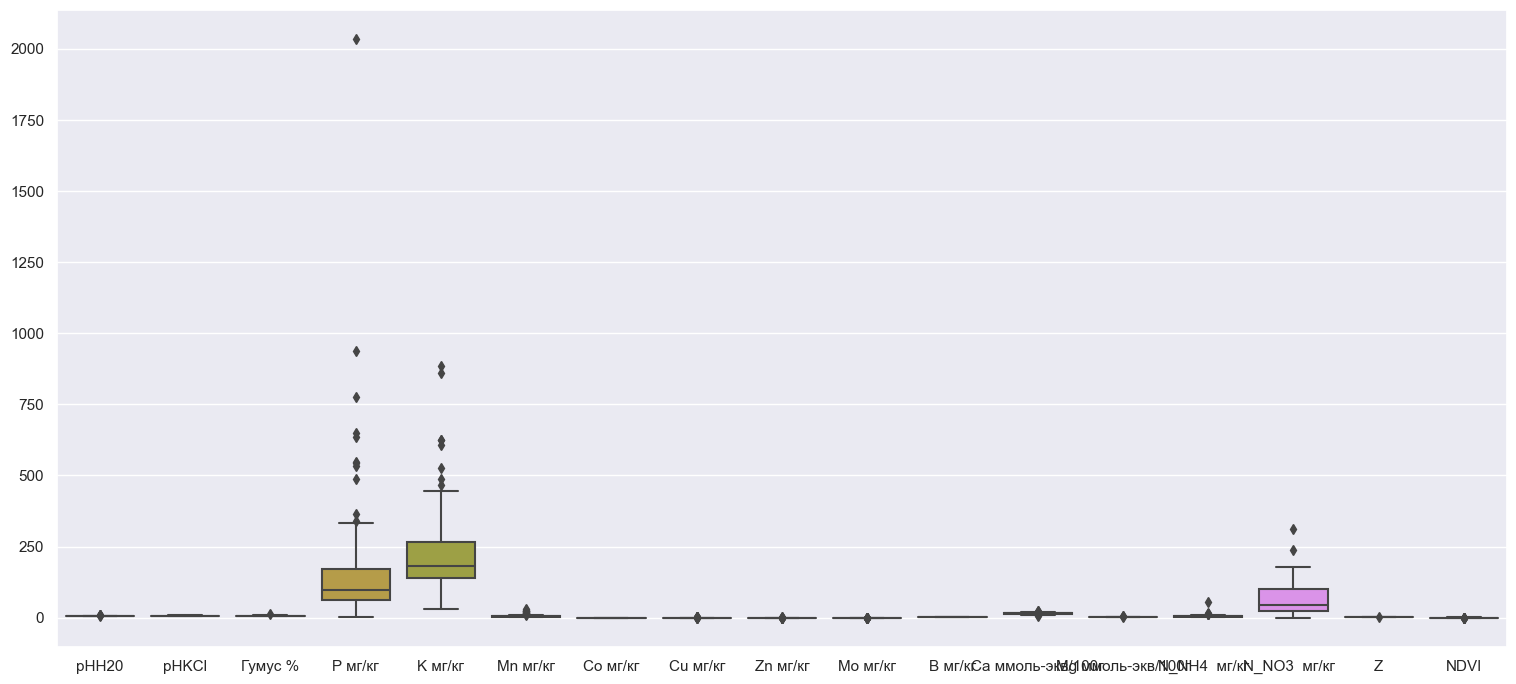

In [1144]:
import seaborn as sns


sns.set(rc={'figure.figsize':(18.7,8.27)})
ax = sns.boxplot(df)  

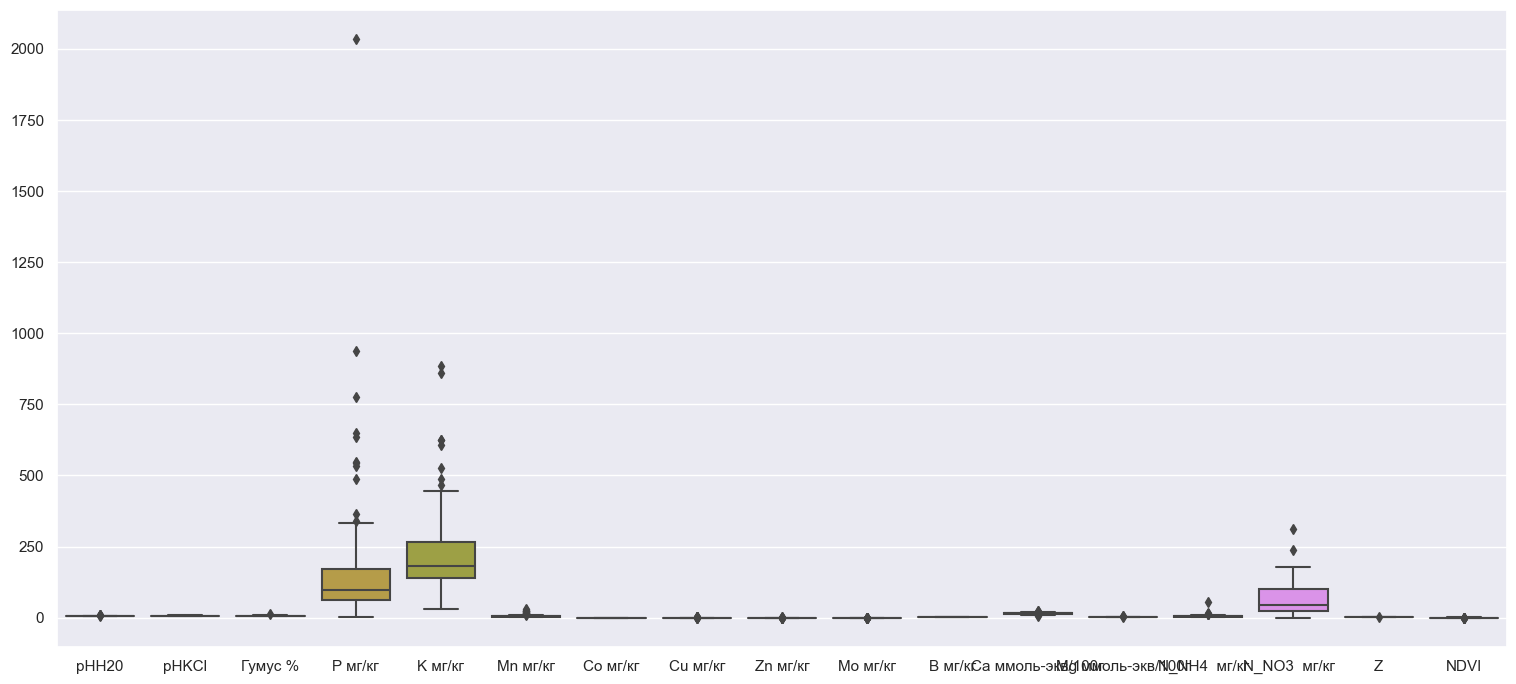

In [1145]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import IsolationForest


iso = IsolationForest()
y_outliers = iso.fit_predict(df)

for i in range(len(y_outliers)):
    if y_outliers[i] == -1:
        df.drop(i, inplace = False)

ax = sns.boxplot(df)  

<AxesSubplot: >

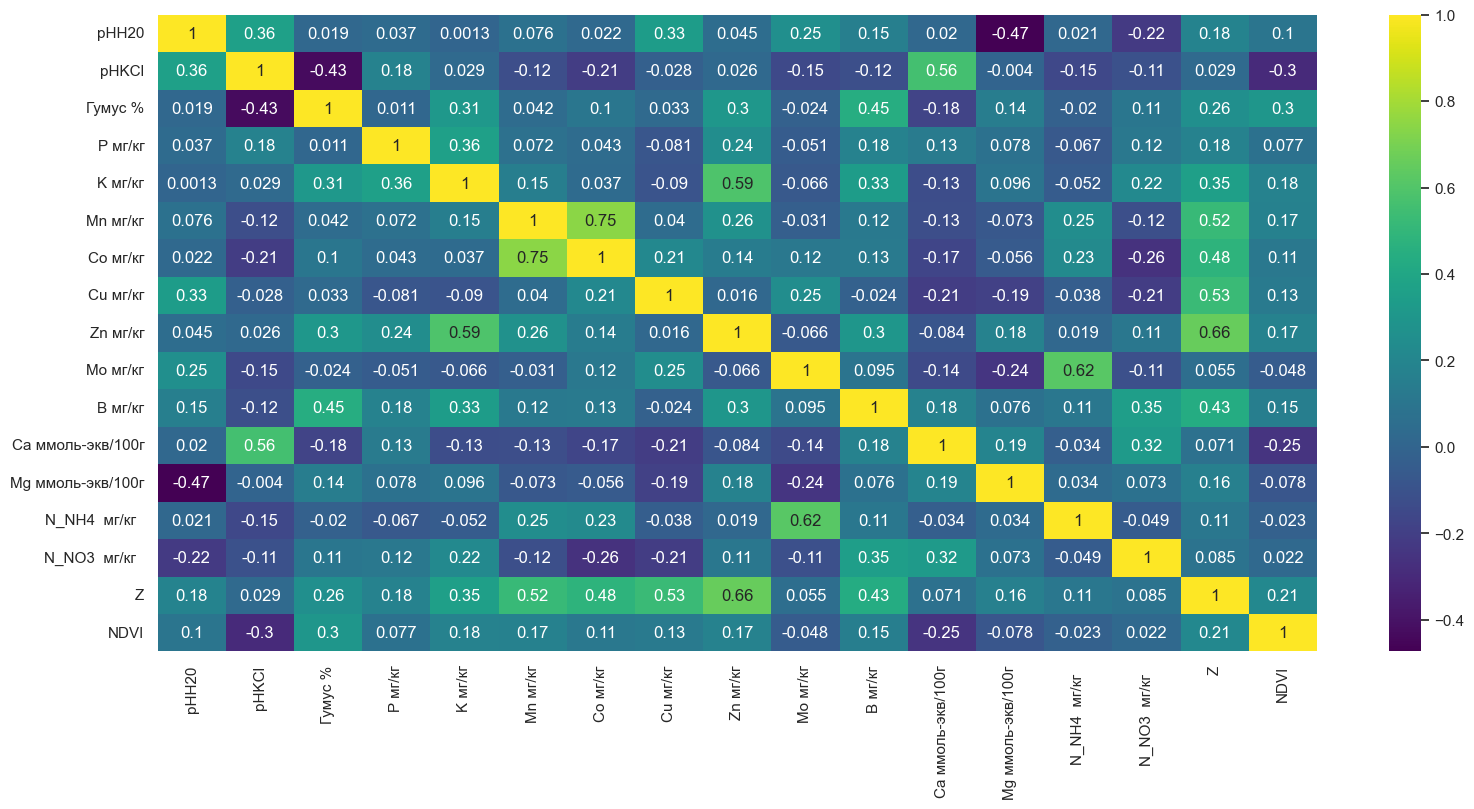

In [1146]:
sns.heatmap(df.corr(),  cmap = 'viridis',annot = True)

In [1147]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

In [1148]:
num_of_features_to_select = 10
num_of_features_to_select_start = 5
num_of_features_to_select_end = len(df.columns)

select_k_best_features_test = []
random_forest_features_test = []
rfe_features_test = []

In [1149]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression


for num_of_features_to_select in range(num_of_features_to_select_start, num_of_features_to_select_end):

  best_parameters_selector = SelectKBest(score_func=f_regression, k=num_of_features_to_select)

  selected_parameters_data = best_parameters_selector.fit_transform(X_norm, y)

  filter = best_parameters_selector.get_support()
  features = X.columns

  select_k_best_features = features[filter]

  select_k_best_features_test.append(select_k_best_features)

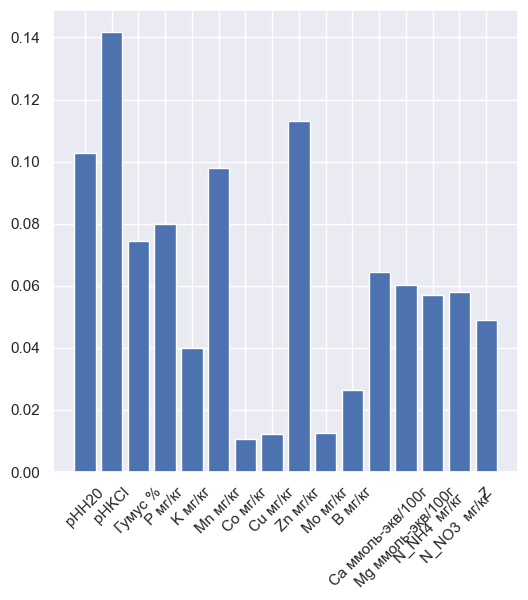

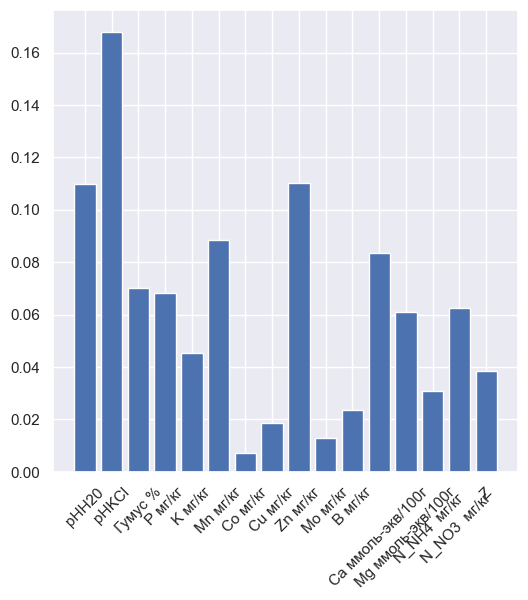

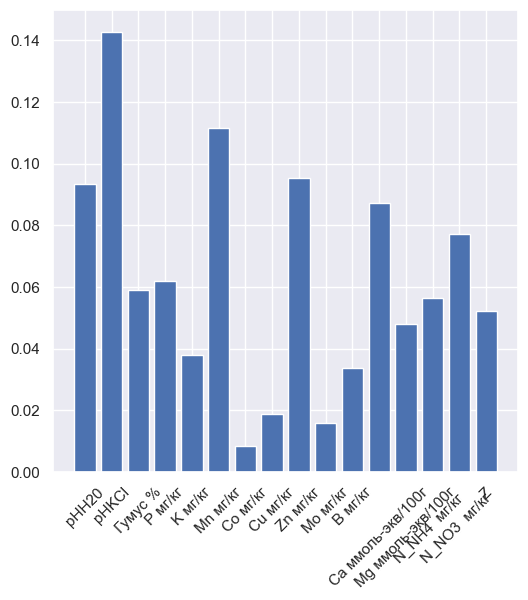

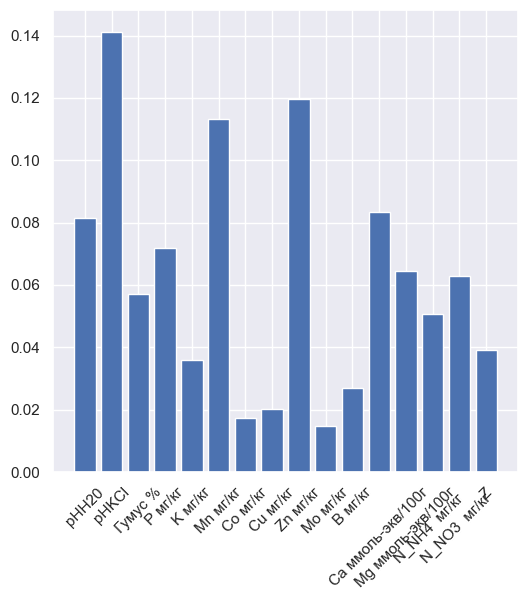

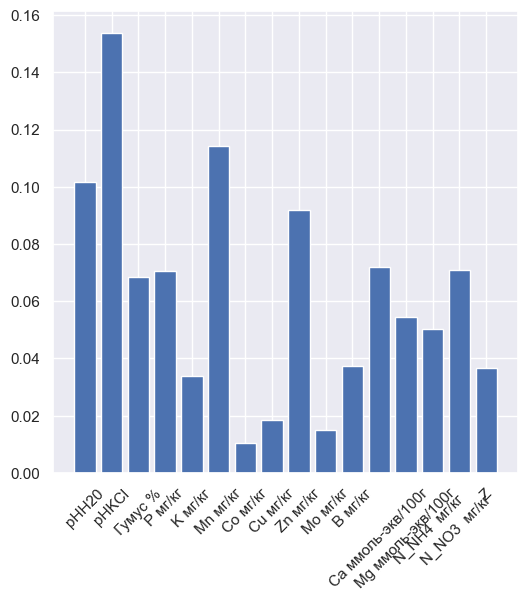

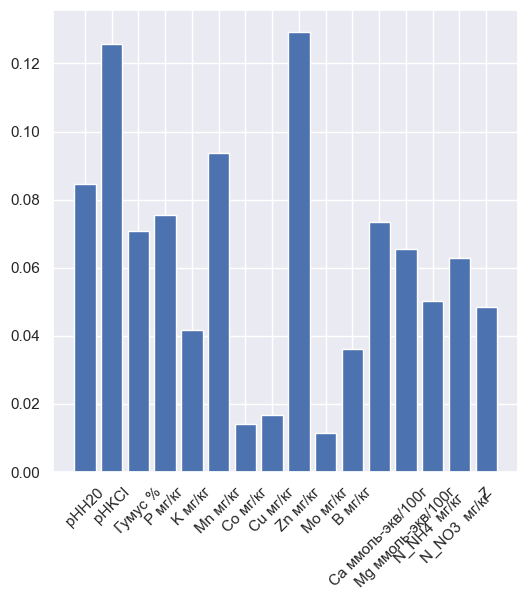

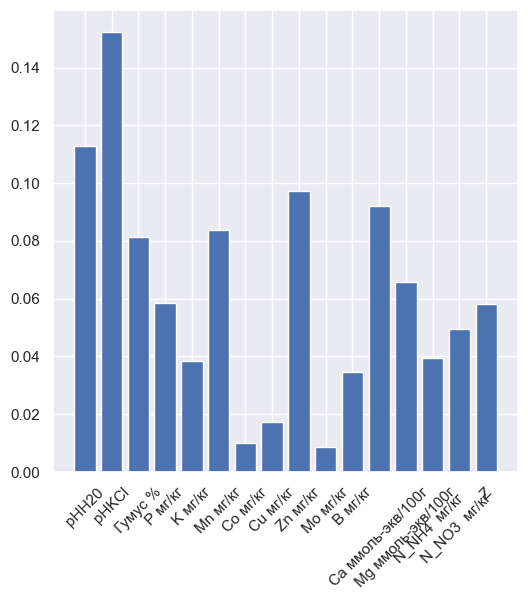

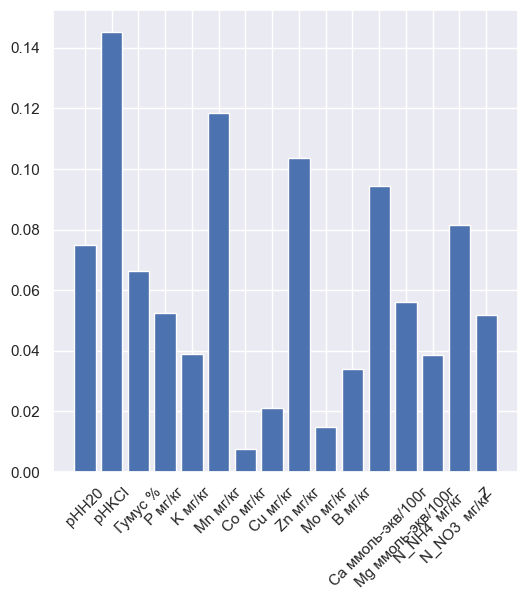

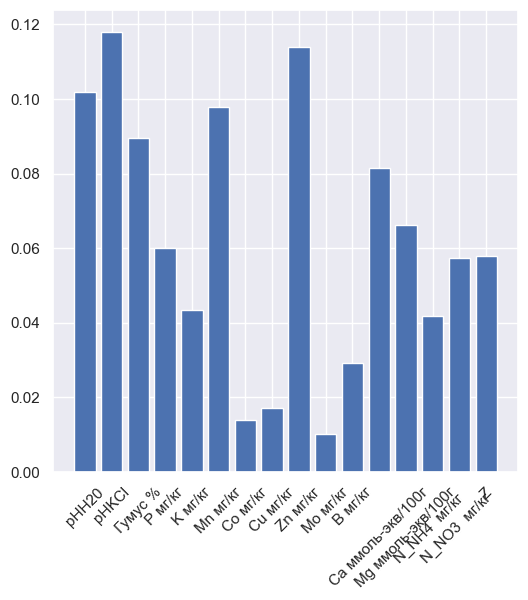

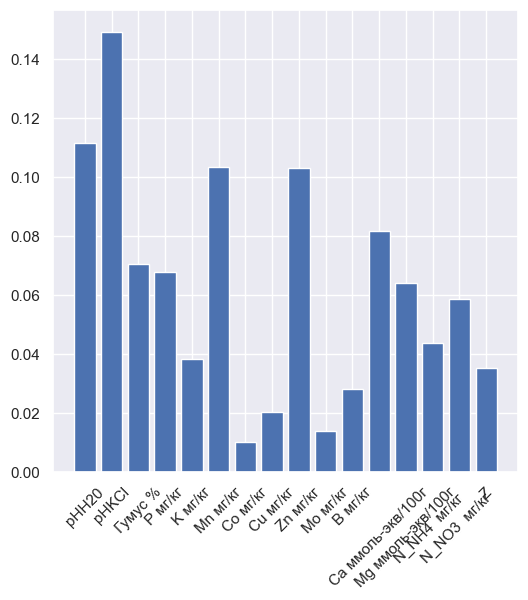

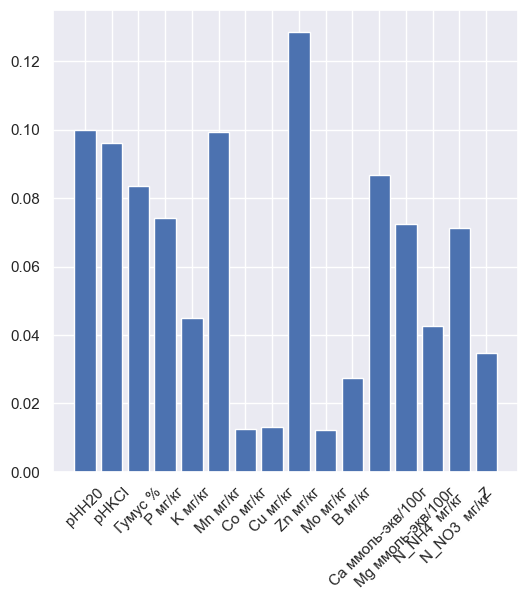

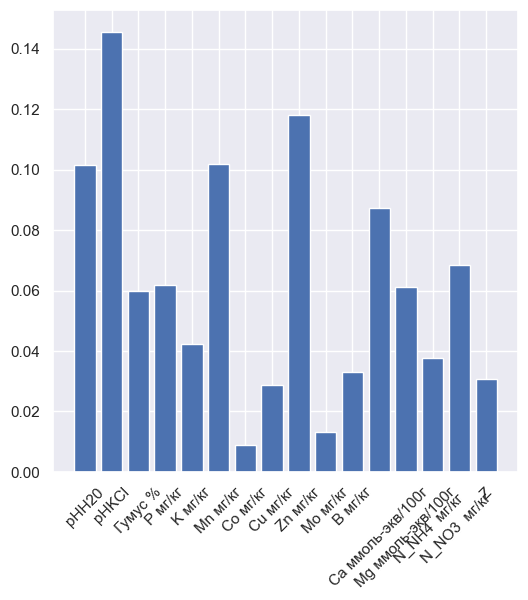

In [1150]:
from sklearn.ensemble import RandomForestRegressor


for num_of_features_to_select in range(num_of_features_to_select_start, num_of_features_to_select_end):
  regr = RandomForestRegressor()
  regr.fit(X_norm, y)
  
  plt.figure(figsize=(6,6))
  plt.bar(X.columns, regr.feature_importances_)
  plt.xticks(rotation=45)

  random_forest_features = {}
  for id in range(len(X.columns)):
    random_forest_features[X.columns[id]] = regr.feature_importances_[id]


  random_forest_features = dict(sorted(random_forest_features.items(), key=lambda item: item[1], reverse=True)[:num_of_features_to_select]).keys()

  random_forest_features_test.append(random_forest_features)

In [1151]:
from sklearn.feature_selection import RFE

for num_of_features_to_select in range(num_of_features_to_select_start, num_of_features_to_select_end):
  rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=num_of_features_to_select)
  rfe_res = rfe.fit_transform(X_norm, y)


  filter = rfe.get_support()
  features = X.columns


  rfe_features = features.values[filter]
  rfe_features_test.append(rfe_features)

In [1152]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [1153]:
X=df.drop('NDVI',axis=1)
Y=df['NDVI']
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size = 0.20, shuffle = True)

In [1154]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR.fit(X_train, Y_train)				#Обучаем модель
Y_LR = LR.predict(X_test)				#Предсказываем значения для выборки    

# print('fakescore', LR.score(X_train, Y_train))


# print ('MAE:', round (mean_absolute_error(Y_test, Y_LR),3))		#Метрики
# print ('√MSE:', round (mean_squared_error(Y_test, Y_LR)**(1/2),3))
print ('R2_score:', round (r2_score(Y_test, Y_LR),3))

R2_score: 0.071


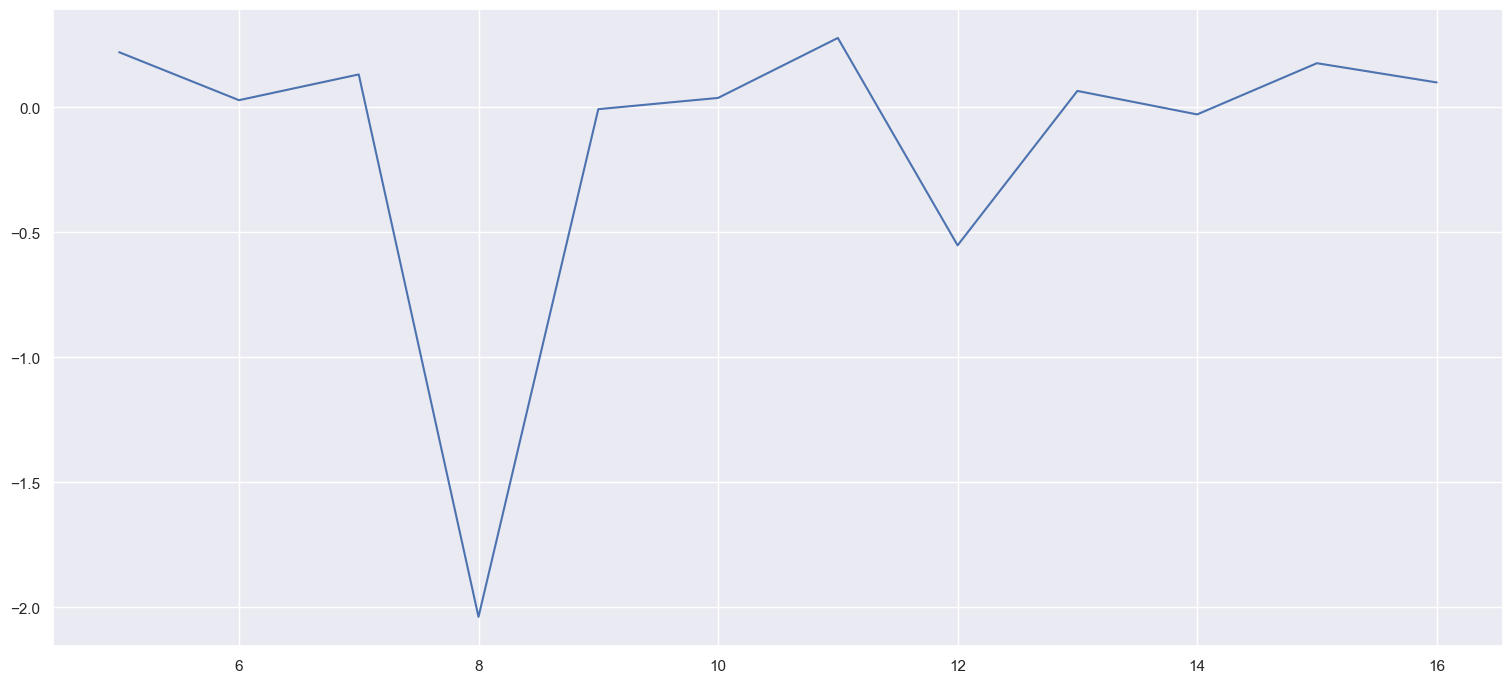

In [1155]:
error_results = []
num_of_selected_vals = []

for select_k_best_features in select_k_best_features_test:
  X=df.drop('NDVI',axis=1)
  X=df[select_k_best_features]
  Y=df['NDVI']


  X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size = 0.20, shuffle = True)

  LR = LinearRegression()
  LR.fit(X_train, Y_train)				#Обучаем модель
  Y_LR = LR.predict(X_test)				#Предсказываем значения для выборки    

  # print('fakescore', LR.score(X_train, Y_train))


  # print ('MAE:', round (mean_absolute_error(Y_test, Y_LR),3))		#Метрики
  # print ('√MSE:', round (mean_squared_error(Y_test, Y_LR)**(1/2),3))
  # print (f'R2_score for {len(select_k_best_features)}:', round (r2_score(Y_test, Y_LR),3))
  error_results.append(round (r2_score(Y_test, Y_LR),3))
  num_of_selected_vals.append(len(select_k_best_features))


plt.plot(num_of_selected_vals, error_results, )

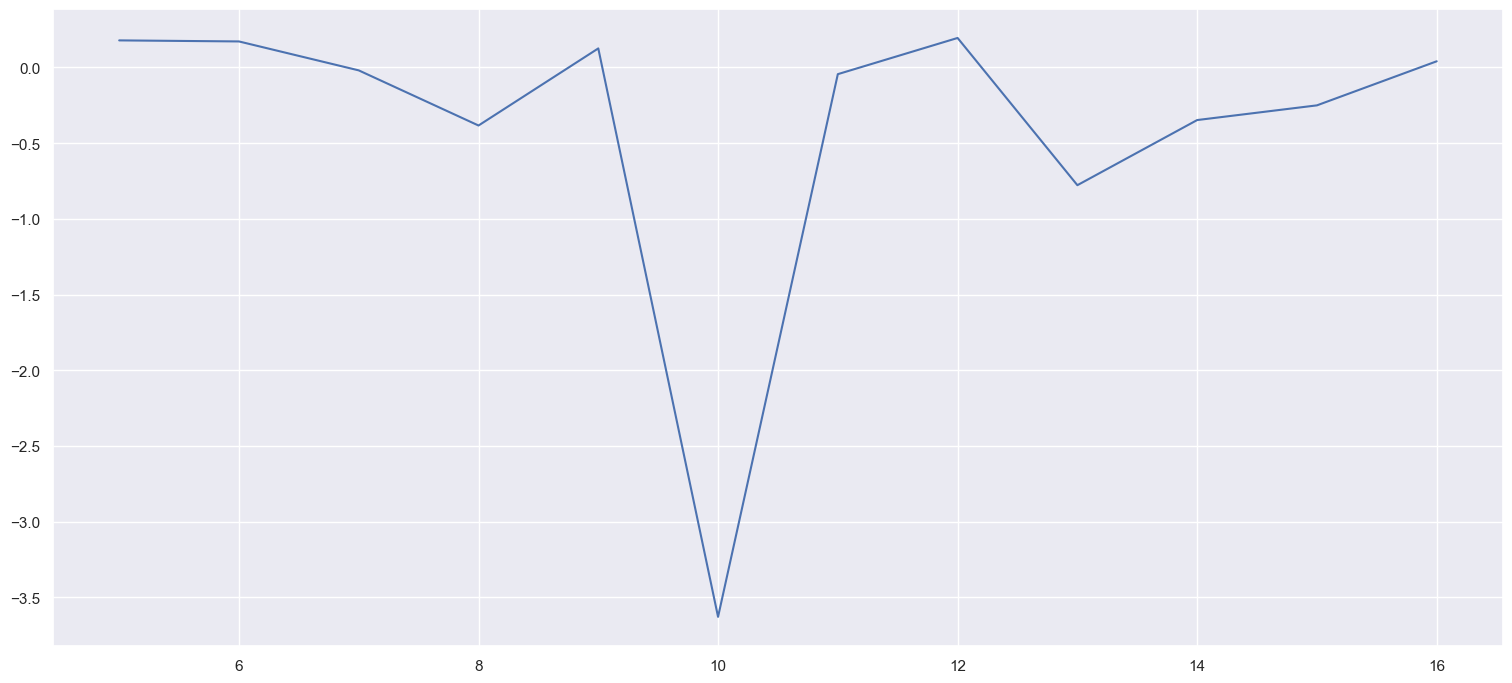

In [1156]:
error_results = []
num_of_selected_vals = []


for random_forest_features in random_forest_features_test:
  X=df.drop('NDVI',axis=1)
  X=df[random_forest_features]
  Y=df['NDVI']


  X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size = 0.20, shuffle = True)

  LR = LinearRegression()
  LR.fit(X_train, Y_train)				#Обучаем модель
  Y_LR = LR.predict(X_test)				#Предсказываем значения для выборки    

  # print('fakescore', LR.score(X_train, Y_train))


  # print ('MAE:', round (mean_absolute_error(Y_test, Y_LR),3))		#Метрики
  # print ('√MSE:', round (mean_squared_error(Y_test, Y_LR)**(1/2),3))
  # print (f'R2_score for {len(random_forest_features)}:', round (r2_score(Y_test, Y_LR),3))
  error_results.append(round (r2_score(Y_test, Y_LR),3))
  num_of_selected_vals.append(len(random_forest_features))

plt.plot(num_of_selected_vals, error_results, )

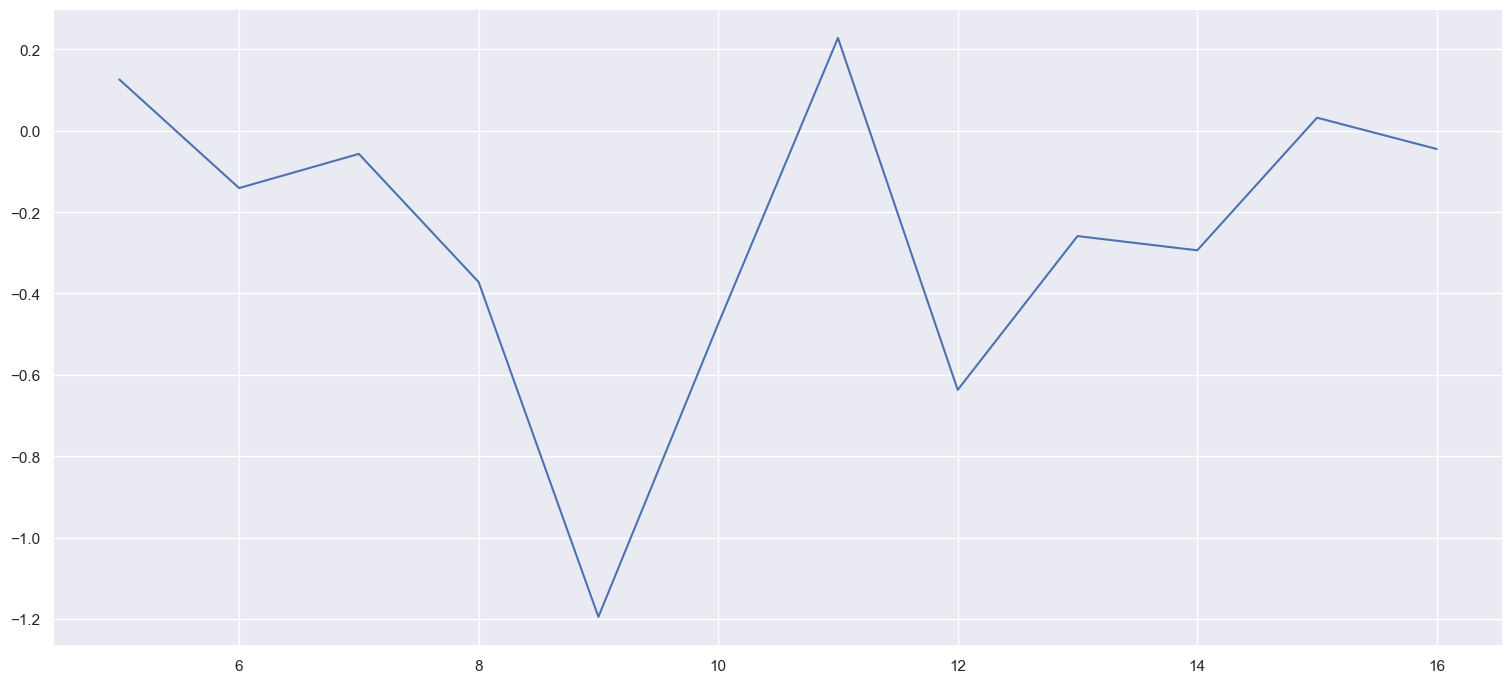

In [1157]:
error_results = []
num_of_selected_vals = []


for rfe_features in rfe_features_test:
  X=df.drop('NDVI',axis=1)
  X=df[rfe_features]
  Y=df['NDVI']


  X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size = 0.20, shuffle = True)

  LR = LinearRegression()
  LR.fit(X_train, Y_train)				#Обучаем модель
  Y_LR = LR.predict(X_test)				#Предсказываем значения для выборки    

  # print('fakescore', LR.score(X_train, Y_train))


  # print ('MAE:', round (mean_absolute_error(Y_test, Y_LR),3))		#Метрики
  # print ('√MSE:', round (mean_squared_error(Y_test, Y_LR)**(1/2),3))
  # print (f'R2_score for {len(rfe_features)}: ', round (r2_score(Y_test, Y_LR),3))

  error_results.append(round (r2_score(Y_test, Y_LR),3))
  num_of_selected_vals.append(len(rfe_features))


plt.plot(num_of_selected_vals, error_results, )

In [1158]:
final_selected_features = random_forest_features_test[3]
print(len(final_selected_features))

8


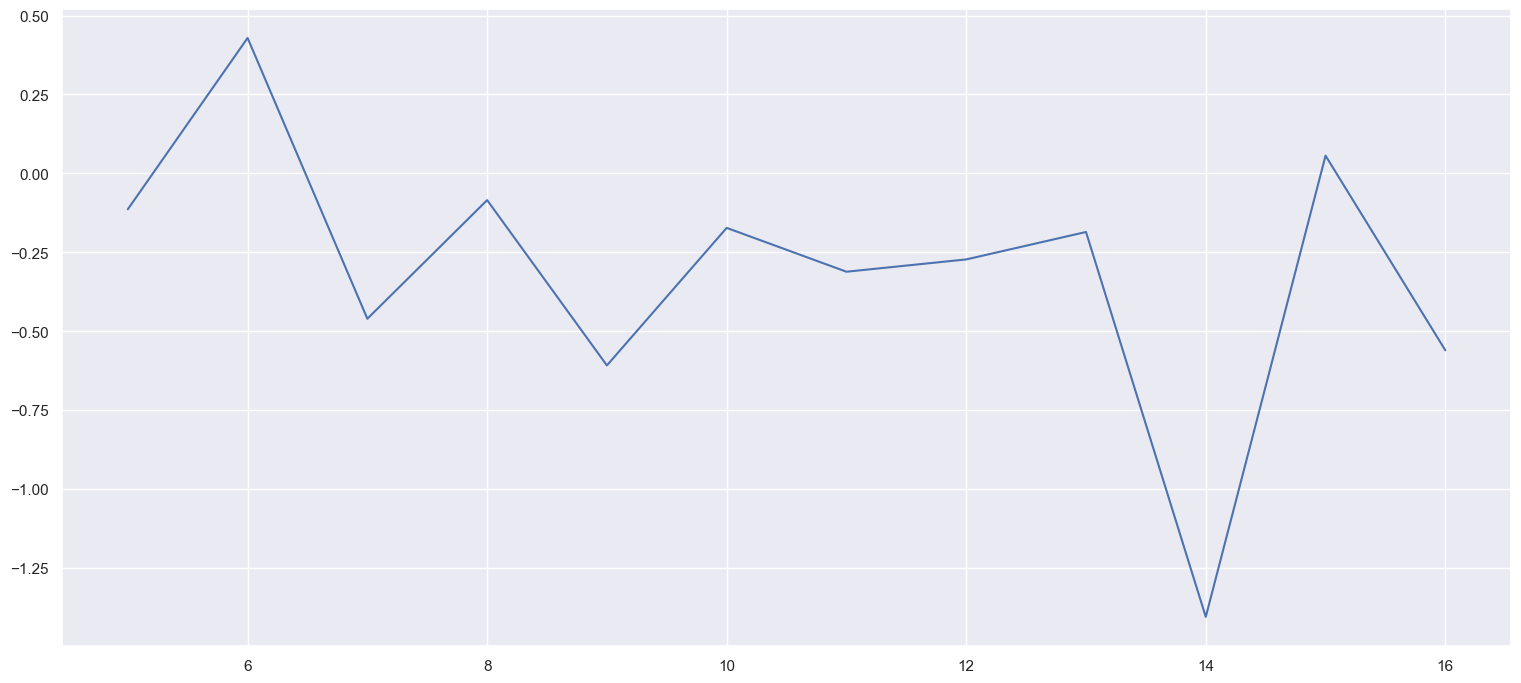

In [1159]:
from sklearn.neighbors import KNeighborsRegressor


error_results = []
num_of_selected_vals = []


for random_forest_features in random_forest_features_test:
  X=df.drop('NDVI',axis=1)
  X=df[random_forest_features]
  Y=df['NDVI']


  X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size = 0.20, shuffle = True)

  LR = KNeighborsRegressor()
  LR.fit(X_train, Y_train)				#Обучаем модель
  Y_LR = LR.predict(X_test)				#Предсказываем значения для выборки    

  # print('fakescore', LR.score(X_train, Y_train))


  # print ('MAE:', round (mean_absolute_error(Y_test, Y_LR),3))		#Метрики
  # print ('√MSE:', round (mean_squared_error(Y_test, Y_LR)**(1/2),3))
  # print (f'R2_score for {len(rfe_features)}: ', round (r2_score(Y_test, Y_LR),3))


  error_results.append(round (r2_score(Y_test, Y_LR),3))
  num_of_selected_vals.append(len(random_forest_features))


plt.plot(num_of_selected_vals, error_results, )

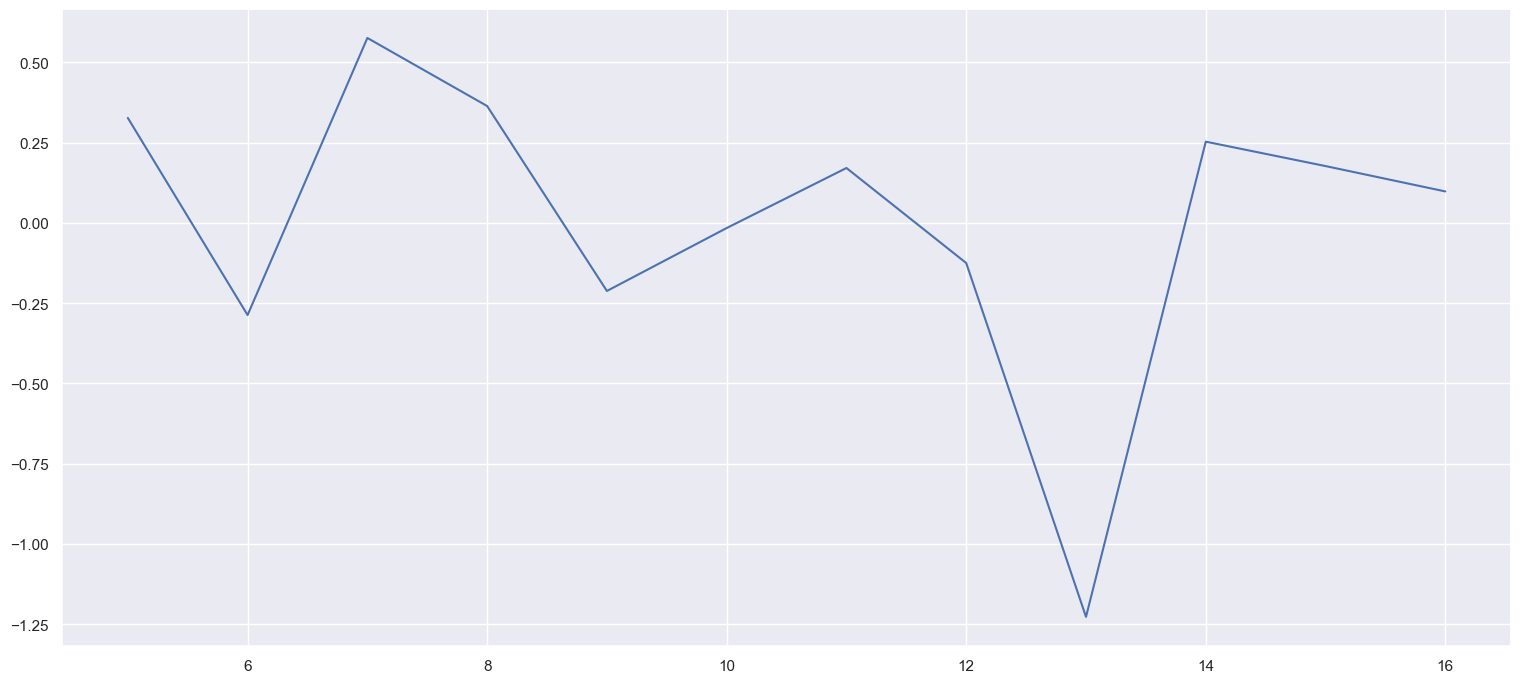

In [1160]:
from sklearn.ensemble import RandomForestRegressor


error_results = []
num_of_selected_vals = []


for random_forest_features in random_forest_features_test:
  X=df.drop('NDVI',axis=1)
  X=df[random_forest_features]
  Y=df['NDVI']


  X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size = 0.20, shuffle = True)

  LR = RandomForestRegressor()
  LR.fit(X_train, Y_train)				#Обучаем модель
  Y_LR = LR.predict(X_test)				#Предсказываем значения для выборки    

  # print('fakescore', LR.score(X_train, Y_train))


  # print ('MAE:', round (mean_absolute_error(Y_test, Y_LR),3))		#Метрики
  # print ('√MSE:', round (mean_squared_error(Y_test, Y_LR)**(1/2),3))
  # print (f'R2_score for {len(rfe_features)}: ', round (r2_score(Y_test, Y_LR),3))

  error_results.append(round (r2_score(Y_test, Y_LR),3))
  num_of_selected_vals.append(len(random_forest_features))


plt.plot(num_of_selected_vals, error_results, )

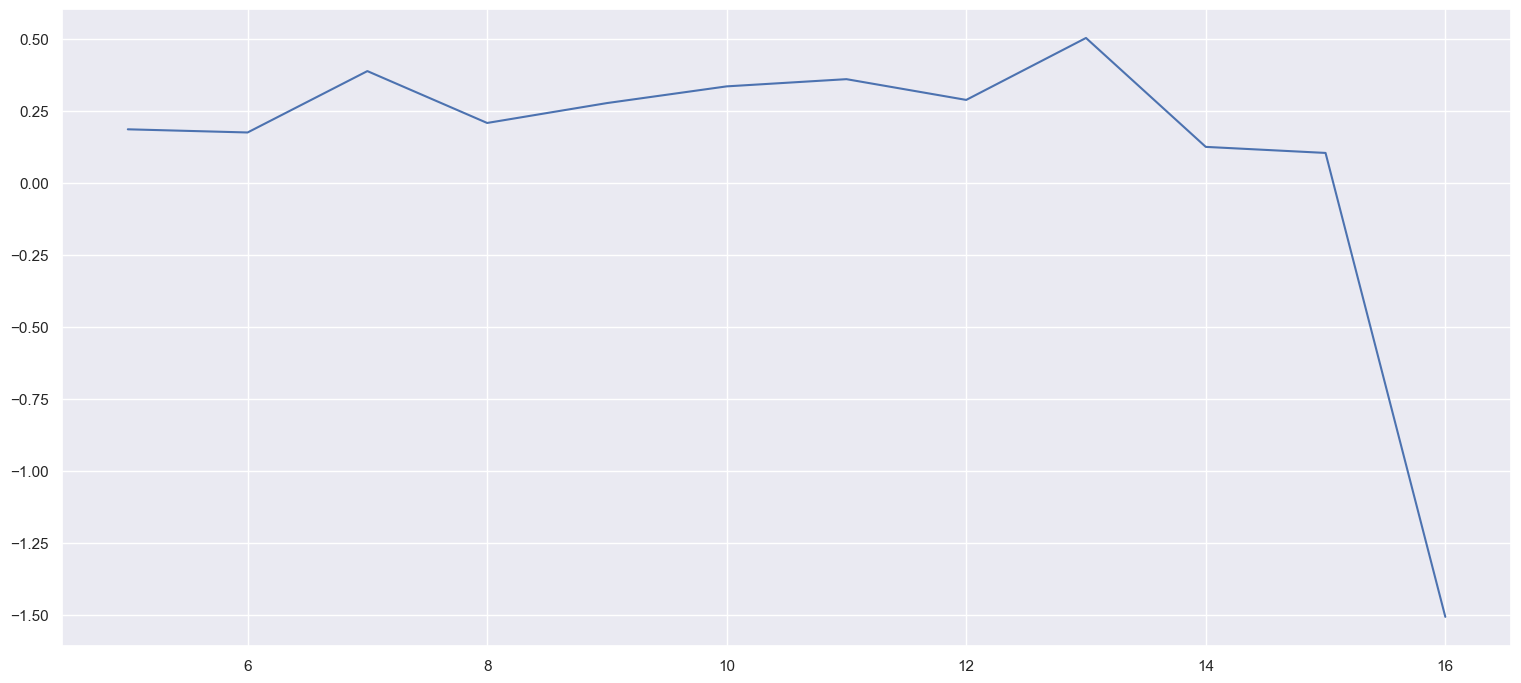

In [1161]:
# best method

from sklearn.ensemble import ExtraTreesRegressor


error_results = []
num_of_selected_vals = []


for random_forest_features in random_forest_features_test:
  X=df.drop('NDVI',axis=1)
  X=df[random_forest_features]
  Y=df['NDVI']


  X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size = 0.20, shuffle = True)

  LR = ExtraTreesRegressor()
  LR.fit(X_train, Y_train)				#Обучаем модель
  Y_LR = LR.predict(X_test)				#Предсказываем значения для выборки    

  # print('fakescore', LR.score(X_train, Y_train))


  # print ('MAE:', round (mean_absolute_error(Y_test, Y_LR),3))		#Метрики
  # print ('√MSE:', round (mean_squared_error(Y_test, Y_LR)**(1/2),3))
  # print (f'R2_score for {len(rfe_features)}: ', round (r2_score(Y_test, Y_LR),3))

  error_results.append(round (r2_score(Y_test, Y_LR),3))
  num_of_selected_vals.append(len(random_forest_features))


plt.plot(num_of_selected_vals, error_results, )

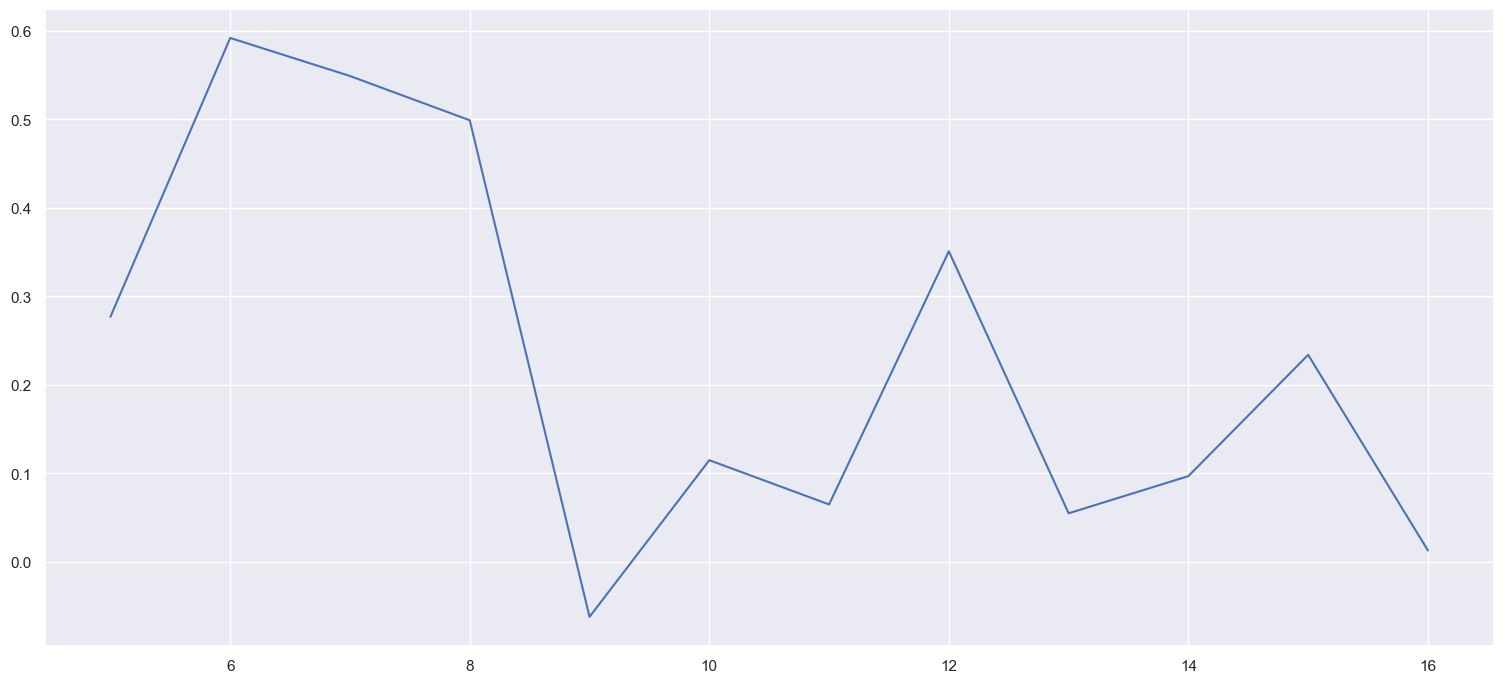

In [1162]:
from sklearn.ensemble import ExtraTreesRegressor


error_results = []
num_of_selected_vals = []


for random_forest_features in rfe_features_test:
  X=df.drop('NDVI',axis=1)
  X=df[random_forest_features]
  Y=df['NDVI']


  X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size = 0.20, shuffle = True)

  LR = ExtraTreesRegressor()
  LR.fit(X_train, Y_train)				#Обучаем модель
  Y_LR = LR.predict(X_test)				#Предсказываем значения для выборки    

  # print('fakescore', LR.score(X_train, Y_train))


  # print ('MAE:', round (mean_absolute_error(Y_test, Y_LR),3))		#Метрики
  # print ('√MSE:', round (mean_squared_error(Y_test, Y_LR)**(1/2),3))
  # print (f'R2_score for {len(rfe_features)}: ', round (r2_score(Y_test, Y_LR),3))

  error_results.append(round (r2_score(Y_test, Y_LR),3))
  num_of_selected_vals.append(len(random_forest_features))


plt.plot(num_of_selected_vals, error_results, )

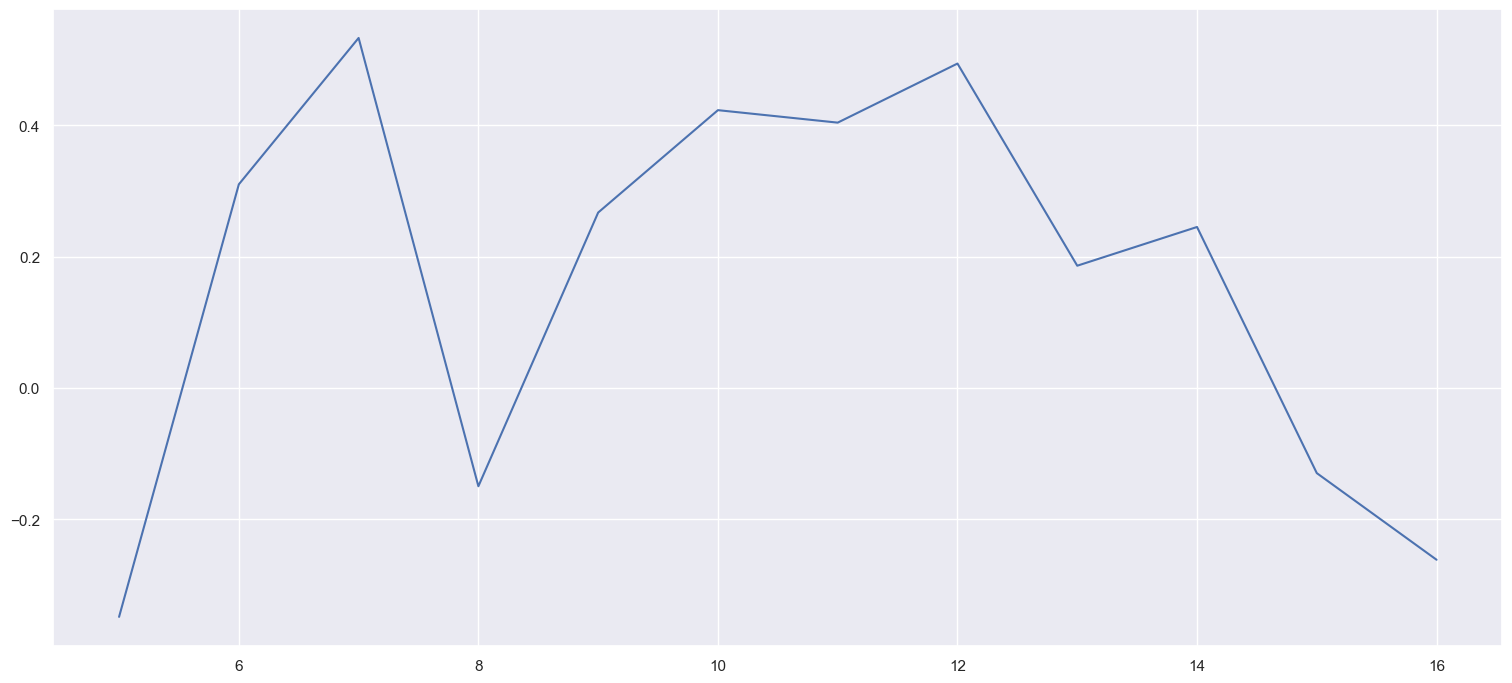

In [1163]:
from sklearn.ensemble import ExtraTreesRegressor


error_results = []
num_of_selected_vals = []


for random_forest_features in select_k_best_features_test:
  X=df.drop('NDVI',axis=1)
  X=df[random_forest_features]
  Y=df['NDVI']


  X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size = 0.20, shuffle = True)

  LR = ExtraTreesRegressor()
  LR.fit(X_train, Y_train)				#Обучаем модель
  Y_LR = LR.predict(X_test)				#Предсказываем значения для выборки    

  # print('fakescore', LR.score(X_train, Y_train))


  # print ('MAE:', round (mean_absolute_error(Y_test, Y_LR),3))		#Метрики
  # print ('√MSE:', round (mean_squared_error(Y_test, Y_LR)**(1/2),3))
  # print (f'R2_score for {len(rfe_features)}: ', round (r2_score(Y_test, Y_LR),3))

  error_results.append(round (r2_score(Y_test, Y_LR),3))
  num_of_selected_vals.append(len(random_forest_features))


plt.plot(num_of_selected_vals, error_results, )

In [1164]:
optimal_features = random_forest_features_test[3]

In [1165]:
X=df[random_forest_features]
Y=df['NDVI']


X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size = 0.20, shuffle = True)

LR = ExtraTreesRegressor()
LR.fit(X_train, Y_train)				#Обучаем модель
Y_LR = LR.predict(X_test)				#Предсказываем значения для выборки    

# print('fakescore', LR.score(X_train, Y_train))


# print ('MAE:', round (mean_absolute_error(Y_test, Y_LR),3))		#Метрики
# print ('√MSE:', round (mean_squared_error(Y_test, Y_LR)**(1/2),3))
print (f'R2_score for {len(rfe_features)}: ', round (r2_score(Y_test, Y_LR),3))

R2_score for 16:  -0.038


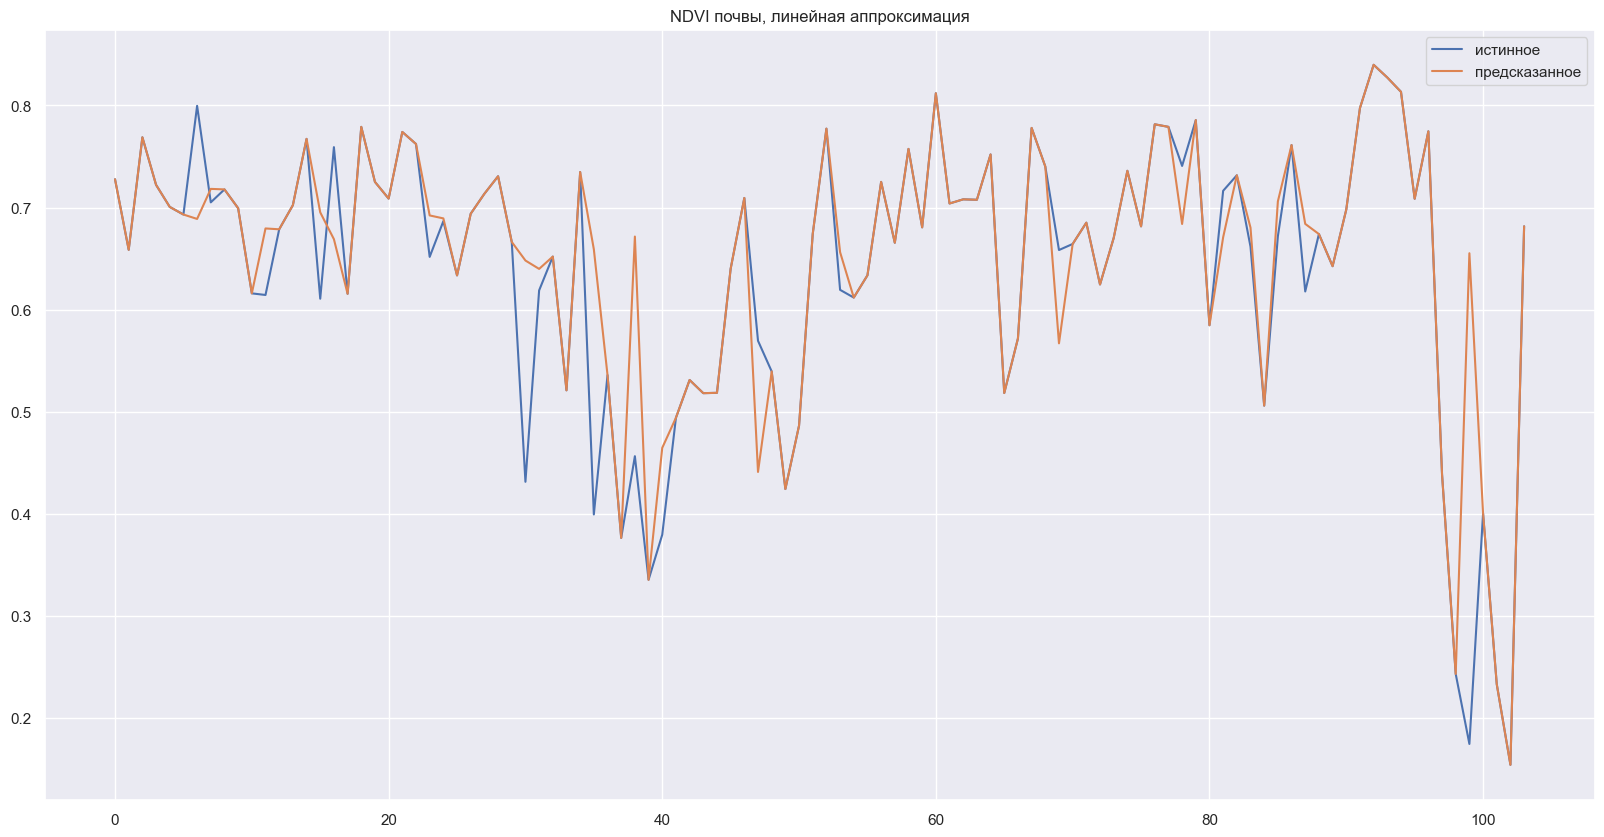

In [1166]:
predicted_NDVI = LR.predict(X)
real_NDVI = df['NDVI']

fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(10)
plt.title("NDVI почвы, линейная аппроксимация")

plt.plot(real_NDVI, label="истинное")
plt.plot(predicted_NDVI, label="предсказанное")

plt.legend()
plt.show()

0.717805803


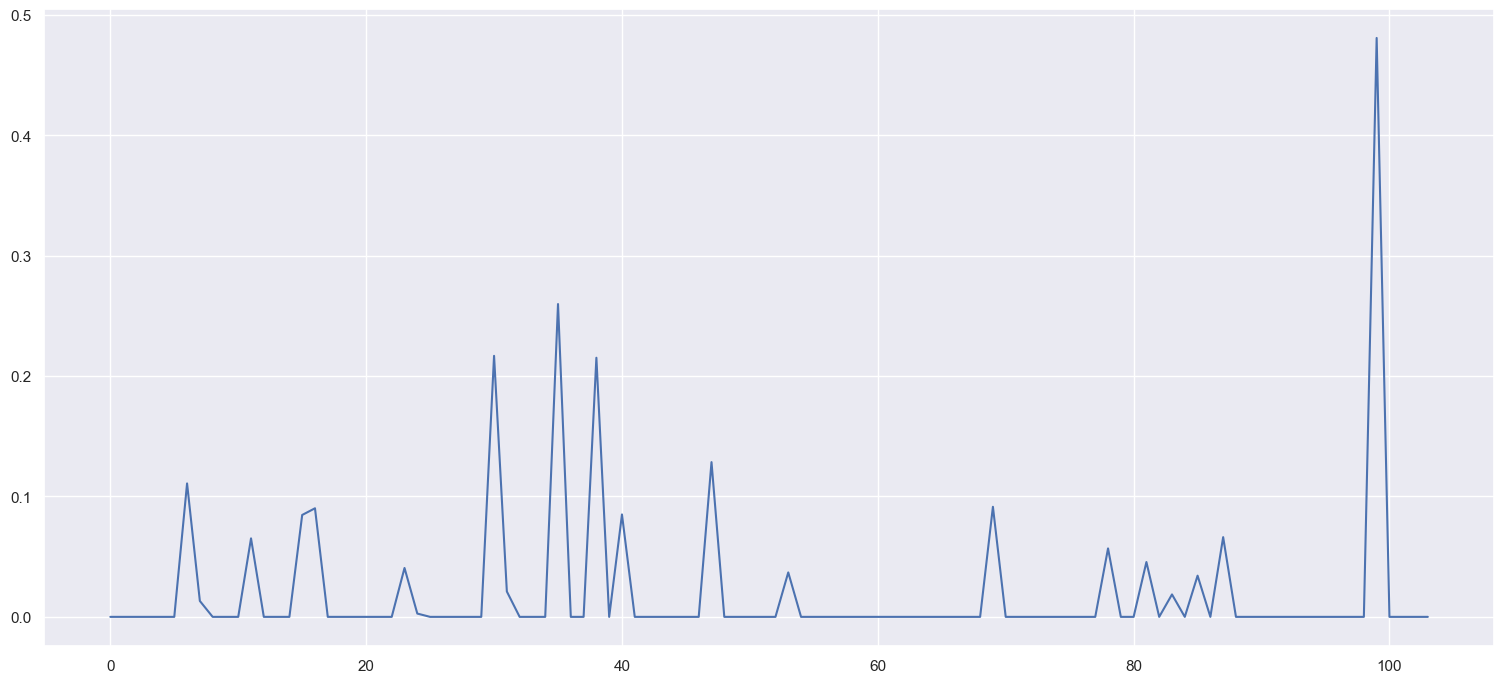

In [1169]:
eror_list = []
print(real_NDVI[8])
for x in range(0, len(real_NDVI)):
    eror = abs(real_NDVI[x] - predicted_NDVI[x])
    eror_list.append(eror)

plt.plot(eror_list)

R2 1.0


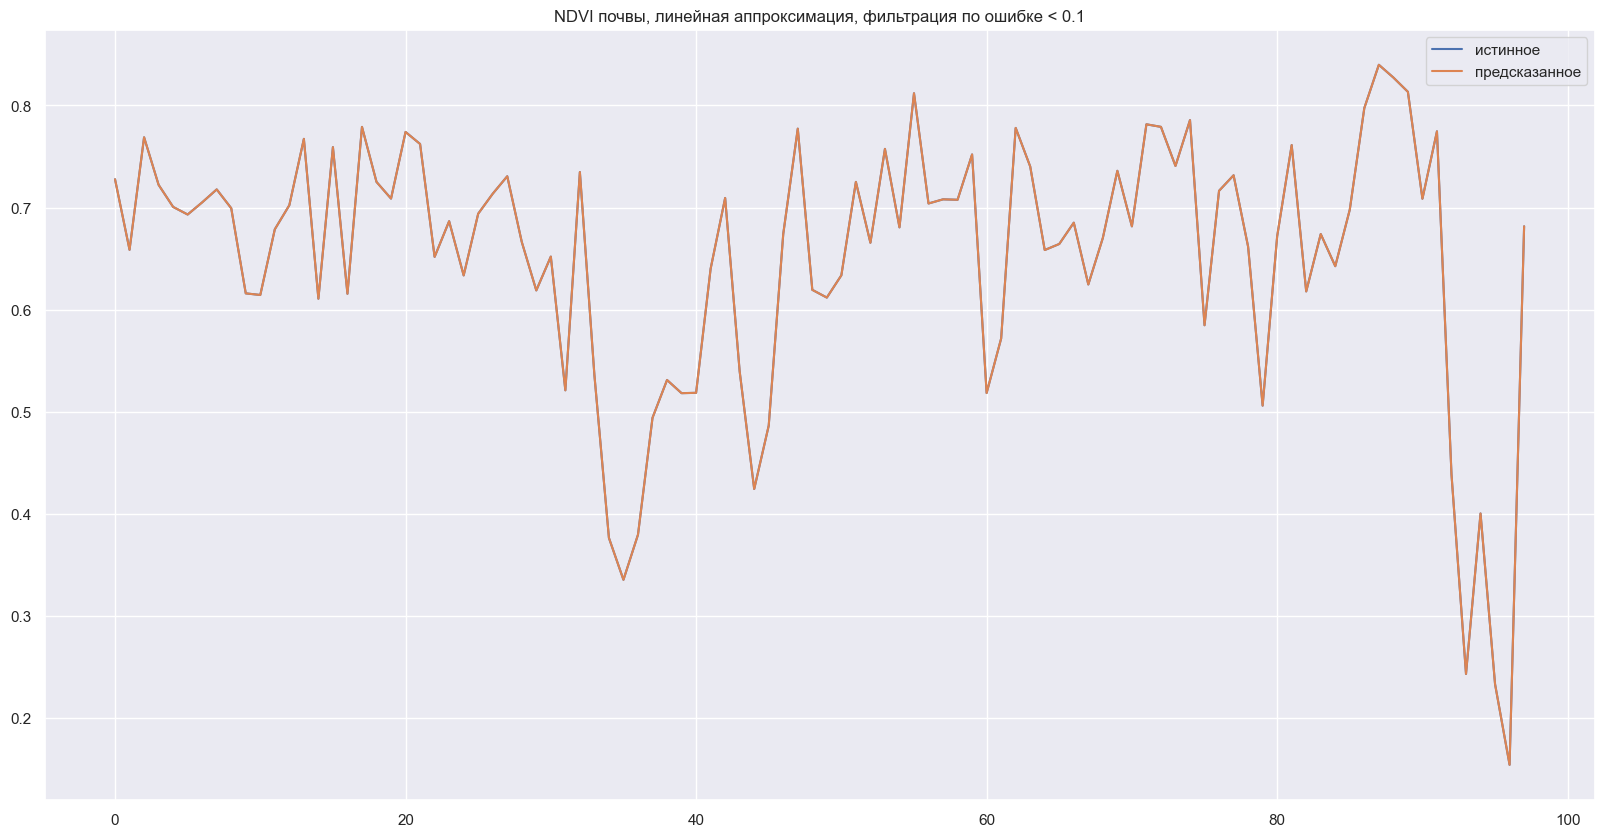

In [1223]:
MAX_ERR = 0.1

filtered_ids = []
filtered_data = []
filtered_NDVI = np.array([])


X=np.array(X)
Y=df['NDVI']


for x in range(0, len(df['NDVI'])):
    err = abs(real_NDVI[x] - predicted_NDVI[x])
 
    if err < MAX_ERR:
        filtered_ids.append(int(x))
        filtered_data.append(X[x])
        filtered_NDVI = np.append(filtered_NDVI, real_NDVI[x])

filtered_data = np.array(filtered_data)    
    
model = ExtraTreesRegressor()
model.fit(filtered_data, filtered_NDVI)


X_train, X_test, Y_train, Y_test  = train_test_split(filtered_data, filtered_NDVI, test_size = 0.20, shuffle = True)

r_sq = model.score(X_test, Y_test)
print("R2", r_sq)

predict = model.predict(filtered_data)

fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(10)
plt.title(f'NDVI почвы, линейная аппроксимация, фильтрация по ошибке < { MAX_ERR }')

plt.plot(filtered_NDVI, label="истинное")
plt.plot(predict, label="предсказанное")

plt.legend()
plt.show()